# Comparing the different Models

In this notebook we comapre the saved models on TRAINING data. We do this, so we can have an intermediate look at the results, without using the eval data, so we don't overfit (subconciously) on the eval data

In [30]:
import numpy as np
import cv2
from PIL import Image
import os
from tqdm import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from math import ceil

from utils.preprocessing import preprocessing_flownet, preprocessing_pwc
from utils.load_models import load_flownet2, load_pwcnet, init_weights
from utils.plotting import flow2img, overlaySegment, showFlow
from utils.layers import warp, warpImage
from utils.encoding import labelMatrixOneHot, dice_coeff


from models.pdd_net.pdd_student import OBELISK2d

# Select a GPU for the work
os.environ["CUDA_VISIBLE_DEVICES"] = '1'
available_gpus = [(torch.cuda.device(i),torch.cuda.get_device_name(i)) for i in range(torch.cuda.device_count())]
print(available_gpus)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

[(<torch.cuda.device object at 0x7f9093350ac0>, 'GeForce RTX 2080 Ti')]


device(type='cuda', index=0)

In [31]:
imgs = torch.load('data/train_frames.pth')
segs = torch.load('data/train_segs.pth')

#define a training split 
torch.manual_seed(42)
# Now, we prepare our train & test dataset.
train_set = torch.from_numpy(np.random.choice(np.arange(len(imgs)),size=int(len(imgs)*0.95), replace=False))

test_set = torch.arange(len(imgs))
for idx in train_set:
    test_set = test_set[test_set != idx]


print(f"{train_set.shape[0]} train examples")
print(f"{test_set.shape[0]} test examples")

1135 train examples
60 test examples


In [3]:
def evaluate_model(model):
    model.eval()
    overall_dice = []
    unwarped_dice = []
    
    for i,idx in enumerate(test_set):
        
        fixed = imgs[idx:idx+1,0,:].unsqueeze(0).float()
        moving = imgs[idx:idx+1,1,:].unsqueeze(0).float()

        fixed_seg = segs[idx:idx+1,0,:].long().contiguous()
        moving_seg = segs[idx:idx+1,1,:].long().contiguous()
        
        # Some images have no segmentation to them, 
        # even if it was present in the directory
        # We leave these ones out, as they cannot be avaluated
        if fixed_seg.max() < 0.1 and moving_seg.max() < 0.1:
            pass
        else:
        
            with torch.no_grad():
                fixed_feat = model(fixed.cuda())
                moving_feat = model(moving.cuda())

            ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
            #regularise using meanfield inference with approx. min-convolutions
            soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
            #upsample field to original resolution
            dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')


            #apply and evaluate transformation
            identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
            warped_student_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

            d1 = dice_coeff(fixed_seg,warped_student_seg.squeeze(),2)
            d2 = dice_coeff(fixed_seg, moving_seg, 2)
            
            overall_dice.append(d1.mean())
            unwarped_dice.append(d2.mean())
    
    overall_dice = torch.from_numpy(np.array(overall_dice))
    unwarped_dice = torch.from_numpy(np.array(unwarped_dice))
    
    print(f"This model has an average Dice of {round(overall_dice.mean().item(), 5)} mit Variance: {round(overall_dice.var().item(), 5)}. The unwarped Mean dice is: {round(unwarped_dice.mean().item(), 5)} with Var {round(unwarped_dice.var().item(),5)}")

# Loading Models

In [54]:
W,H = (150,150)
o_m = H//4
o_n = W//4
ogrid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,o_m,o_n)).view(1,1,-1,2).cuda()
disp_range = 0.25#0.25
displacement_width = 15#15#11#17
shift_xy = F.affine_grid(disp_range*torch.eye(2,3).unsqueeze(0),(1,1,displacement_width,displacement_width)).view(1,1,-1,2).cuda()

grid_size = 32#25#30
grid_xy = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,grid_size,grid_size)).view(1,-1,1,2).cuda()

disp_hw = 5
displace_range = 11

def init_weights(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv3d) or isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.xavier_normal(m.weight)
        if m.bias is not None:
            nn.init.constant(m.bias, 0.0)

class OBELISK2d(nn.Module):
    def __init__(self, chan = 16):

        super(OBELISK2d, self).__init__()
        channels = chan
        self.offsets = nn.Parameter(torch.randn(2,channels *2,2) *0.05)
        self.layer0 = nn.Conv2d(1, 4, 5, stride=2, bias=False, padding=2)
        self.batch0 = nn.BatchNorm2d(4)

        self.layer1 = nn.Conv2d(channels *8, channels *4, 1, bias=False, groups=1)
        self.batch1 = nn.BatchNorm2d(channels *4)
        self.layer2 = nn.Conv2d(channels *4, channels *4, 3, bias=False, padding=1)
        self.batch2 = nn.BatchNorm2d(channels *4)
        self.layer3 = nn.Conv2d(channels *4, channels *1, 1)
        

    def forward(self, input_img):
        img_in = F.avg_pool2d(input_img ,3 ,padding=1 ,stride=2)
        img_in = F.relu(self.batch0(self.layer0(img_in)))
        sampled = F.grid_sample(img_in ,ogrid_xy + self.offsets[0 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)
        sampled -= F.grid_sample(img_in ,ogrid_xy + self.offsets[1 ,:,:].view(1 ,-1 ,1 ,2)).view(1 ,-1 ,o_m ,o_n)

        x = F.relu(self.batch1(self.layer1(sampled)))
        x = F.relu(self.batch2(self.layer2(x)))
        features = self.layer3(x)
        return features


    
def min_convolution(ssd_distance, displace_range, H, W):
    # Prepare operators for smooth dense displacement space
    pad1 = nn.ReplicationPad2d(5)
    avg1 = nn.AvgPool2d(5,stride=1)
    max1 = nn.MaxPool2d(3,stride=1)
    pad2 = nn.ReplicationPad2d(6)
    # approximate min convolution / displacement compatibility

    ssd_minconv = avg1(avg1(-max1(-pad1(ssd_distance.permute(0,2,3,1).reshape(1,-1,displace_range,displace_range)))))

    ssd_minconv = ssd_minconv.permute(0,2,3,1).view(1,-1,H,W)
    min_conv_cost = avg1(avg1(avg1(pad2(ssd_minconv))))
    
    return min_conv_cost

def meanfield(ssd_distance,img_fixed,displace_range,H,W):

    crnt_dev = ssd_distance.device

    cost = min_convolution(ssd_distance, displace_range, H, W)

    soft_cost = F.softmax(-10*cost.view(displace_range**2,-1).t(),1)
    
    disp_hw = (displace_range-1)//2
    disp_mesh_grid = disp_hw*F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,displace_range,displace_range),align_corners=True)
    disp_mesh_grid /= torch.Tensor([(W-1)*.5,(H-1)*.5])

    disp_xy = torch.sum(soft_cost.view(1,H,W,-1,1)*disp_mesh_grid.view(1,1,1,-1,2).to(crnt_dev),3).permute(0,3,1,2) 
    

    return soft_cost,disp_xy

def correlation_layer(displace_range, feat_moving, feat_fixed):
    
    disp_hw = (displace_range-1)//2
    feat_moving_unfold = F.unfold(feat_moving.transpose(1,0),(displace_range,displace_range),padding=disp_hw)
    B,C,H,W = feat_fixed.size()
    
    ssd_distance = ((feat_moving_unfold-feat_fixed.view(C,1,-1))**2).sum(0).view(1,displace_range**2,H,W)

    return ssd_distance

In [5]:
obel_solo = OBELISK2d(24)
obel_solo.load_state_dict(torch.load("models/obel_solo_24.pth"))

obel_mse_warped = OBELISK2d(24)
obel_mse_warped.load_state_dict(torch.load("models/obel_MSE_warped.pth"))

obel_mse_teacher_flow = OBELISK2d(24)
obel_mse_teacher_flow.load_state_dict(torch.load("models/obel_MSE_teacher_flow.pth"))

obel_weighted_teacher = OBELISK2d(24)
obel_weighted_teacher.load_state_dict(torch.load("models/obel_MSE_weighted_warped.pth"))

obel_kl_div = OBELISK2d(24)
obel_kl_div.load_state_dict(torch.load("models/obel_klDiv.pth"))

<All keys matched successfully>

In [6]:
print("obel Solo")
evaluate_model(obel_solo.cuda())

print("KL Divergence")
evaluate_model(obel_kl_div.cuda())

print("MSE Warped")
evaluate_model(obel_mse_warped.cuda())

print("MSE Teacher Flow")
evaluate_model(obel_mse_teacher_flow.cuda())

print("MSE Weighted Teacher")
evaluate_model(obel_weighted_teacher.cuda())

obel Solo
This model has an average Dice of 0.8972 mit Variance: 0.00565. The unwarped Mean dice is: 0.76379 with Var 0.04105
KL Divergence
This model has an average Dice of 0.82547 mit Variance: 0.01537. The unwarped Mean dice is: 0.76379 with Var 0.04105
MSE Warped
This model has an average Dice of 0.73358 mit Variance: 0.03207. The unwarped Mean dice is: 0.76379 with Var 0.04105
MSE Teacher Flow
This model has an average Dice of 0.83429 mit Variance: 0.01186. The unwarped Mean dice is: 0.76379 with Var 0.04105
MSE Weighted Teacher
This model has an average Dice of 0.7112 mit Variance: 0.03375. The unwarped Mean dice is: 0.76379 with Var 0.04105


# Plots to show

Dice of warped: tensor([0.8984]) vs unwarped dice: tensor([0.5779])


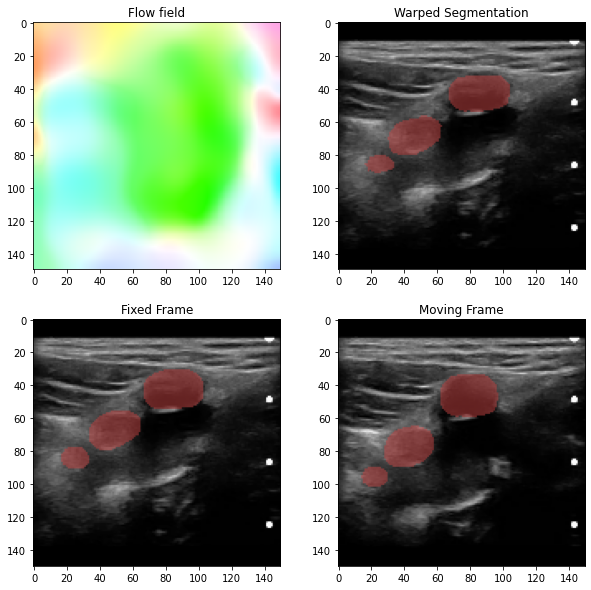

In [25]:
obel_solo.eval()
rnd_test_idx = torch.randperm(test_set.size(0))
p_fix = test_set[rnd_test_idx[0]]

fixed = imgs[p_fix:p_fix+1,0,:].unsqueeze(0).float()
moving = imgs[p_fix:p_fix+1,1,:].unsqueeze(0).float()

fixed_seg = segs[p_fix:p_fix+1,0,:].long().contiguous()
moving_seg = segs[p_fix:p_fix+1,1,:].long().contiguous()


with torch.no_grad():
    fixed_feat = obel_solo(fixed.cuda())
    moving_feat = obel_solo(moving.cuda())

ssd_distance = correlation_layer(displace_range, moving_feat, fixed_feat).contiguous()
#regularise using meanfield inference with approx. min-convolutions
soft_cost_one,disp_xy = meanfield(ssd_distance, fixed, displace_range, H//4, W//4)
#upsample field to original resolution
dense_flow_fit = F.interpolate(disp_xy,size=(H,W),mode='bicubic')


#apply and evaluate transformation
identity = F.affine_grid(torch.eye(2,3).unsqueeze(0),(1,1,H,W),align_corners=False).cuda()
warped_student_seg = F.grid_sample(moving_seg.cuda().float().unsqueeze(1),identity+dense_flow_fit.permute(0,2,3,1),mode='nearest',align_corners=False).cpu()

#warped_teacher_seg = warp(moving_seg.unsqueeze(0).float().cuda(),teacher_flow.squeeze().cuda()).cpu()

d1 = dice_coeff(fixed_seg,warped_student_seg.squeeze(),2)
d0 = dice_coeff(fixed_seg,moving_seg,2)
print(f"Dice of warped: {d1} vs unwarped dice: {d0}")

rgb = showFlow(dense_flow_fit.cpu().transpose(-2,-1).flip(1))
overlay = overlaySegment(fixed.squeeze(),warped_student_seg.data.squeeze(),False)

overlay_fixed = overlaySegment(fixed.squeeze(),fixed_seg.data.squeeze(),False)
overlay_moving = overlaySegment(moving.squeeze(),moving_seg.data.squeeze(),False)

fig = plt.figure(figsize=(10,10))
plt.subplot(221)
plt.imshow(rgb)
plt.title("Flow field")
plt.subplot(222)
plt.imshow(overlay)
plt.title("Warped Segmentation")

plt.subplot(223)
plt.imshow(overlay_fixed)
plt.title("Fixed Frame")
plt.subplot(224)
plt.title("Moving Frame")
plt.imshow(overlay_moving)

# Examine Space and Time
In this part we will use torch and timing tools to examine how either the sequential or the obelisk feature extractor would perform on a mobile GPU

In [62]:
import matplotlib.pyplot as plt
import time
from pytorch_model_summary import summary

In [28]:
fixed = imgs[0][0] 
moving = imgs[0][1]

In [59]:
net = OBELISK2d(chan=24).cuda()

In [56]:
with torch.profiler.profile(
    activities=[
        torch.profiler.ProfilerActivity.CPU,
        torch.profiler.ProfilerActivity.CUDA
    ],
    with_flops=True,
    profile_memory=True,
    
) as p:
    feat_fixed = net(fixed.reshape(1,150,150).unsqueeze(0).to(torch.float32).cuda())
    feat_moving = net(moving.reshape(1,150,150).unsqueeze(0).to(torch.float32).cuda())
    ssd_distance = correlation_layer(displace_range, feat_moving, feat_fixed)
    soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, 150//4, 150//4)
print(p.key_averages().table(
    sort_by="self_cuda_time_total"))

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls        MFLOPS  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                           aten::im2col         0.01%     233.000us         0.04%     932.000us     932.000us       1.083ms        61.67%       1.113ms       1.113ms           0 

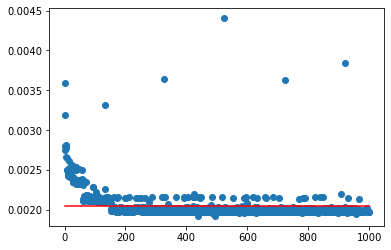

In [61]:
time_array = []
times = 1000
fixed_idx = torch.randperm(n=len(imgs))
fixed = imgs[fixed_idx[0]][0]
begin = time.time()
feat_fixed = net(fixed.reshape(1,150,150).unsqueeze(0).to(torch.float32).cuda())

for i in range(times):
    fixed_idx = torch.randperm(n=len(imgs))
    fixed = imgs[fixed_idx[0]][0,:,:]
    begin = time.time()
    output = net(fixed.reshape(1,150,150).unsqueeze(0).to(torch.float32).cuda())

    ssd_distance = correlation_layer(displace_range, output, feat_fixed)
    soft_cost,disp_xy = meanfield(ssd_distance, fixed, displace_range, 150//4, 150//4)
    end = time.time()
    time_array.append(end-begin)

plt.scatter(np.arange(times), time_array)
plt.plot(np.arange(times), [np.mean(time_array)]*times, color='r')

In [70]:
summary(net.cpu(), (1,150,150))

TypeError: avg_pool2d(): argument 'input' (position 1) must be Tensor, not tuple